# Live tweet extraction, sentiment classification and NER tag extraction

## Motivation

The fundamental idea behind the project is to use 2 separate NLP models to sentiment tag and industry tag tweets. As from the initial scan of tweets by major business tweet handles, the idea of industrial tweet segmentation seems far fetched for the lack of enough tweets concerning a particular industry. Classification of tweets to an industry might in some cases be linked to a derived meaning of the tweet read along with other business news, which is difficult to factor in basis the current efforts. 

The ability of Flair's NER models was all the more compelling to extract NER tags from  tweets. These tags can then be analyzed across sentiment buckets to understand the sentiment co-relation across associated organization, person or country.  This can intern help in understanding the sentiment trend across an industry type or a region. 

## Importing relevant libraries and defining relevant functions

Below I import relevant libraries, classification models and create functions that can pull tweets real-time using the twitter API, sentiment classify and NER tag using pre-trained models defined inside the flair library and further summarize the results for  easy analysis.

### Importing relevant libraries

In [1]:
from tweepy import API
from tweepy import Cursor

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler #Authentication with credentials
from tweepy import Stream #Live Stream API

import twitter_credentials

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

from flair.models import SequenceTagger
tagger = SequenceTagger.load('ner')

2020-08-04 11:30:48,884 loading file C:\Users\govin\.flair\models\sentiment-en-mix-distillbert.pt
2020-08-04 11:30:54,752 loading file C:\Users\govin\.flair\models\en-ner-conll03-v0.4.pt


### Functions to pull tweet feed

In [2]:
def authenticate_twitter_app():
    """
        Function Variables:
           auth -- twitter authenticated object after supplying the crcedentials 
    """
    auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
    auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
    return auth

def retrive_tweets(twitter_client ,user_id, no_of_tweets):
    """
        Input Variables:
            twitter_client -- twitter API object to pull tweets 
            user_id -- the user ID for whcih the tweets are to be pulled
            no_of_tweets -- the count of tweets to be pulled
        Function Variables:
           tweets -- list of tweets pulled by the request
    """
    tweets = []
    for tweet in Cursor(twitter_client.user_timeline, screen_name = user_id, tweet_mode = 'extended').items(no_of_tweets):
        tweets.append(tweet)
    return tweets

def retrive_search_tweets(twitter_client ,search, no_of_tweets):
    """
        Input Variables:
            twitter_client -- twitter API object to pull tweets 
            search -- the search term for whcih the tweets are to be pulled
            no_of_tweets -- the count of tweets to be pulled
        Function Variables:
           tweets -- list of tweets pulled by the request
    """
    tweets = []
    for tweet in Cursor(twitter_client.search, q=search, tweet_mode = 'extended').items(no_of_tweets):
        tweets.append(tweet)
    return tweets

def tweets_to_data_frame(tweets):
    """
        Input Variables:
            tweets -- list of tweets pulled by the request
        Function Variables:
           df -- dataframe containing the tweets
    """
    
    df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

    df['id'] = np.array([tweet.id for tweet in tweets])
    df['len'] = np.array([len(tweet.full_text) for tweet in tweets])
    df['date'] = np.array([tweet.created_at for tweet in tweets])
    df['coordinates'] = np.array([tweet.coordinates for tweet in tweets])
    df['source'] = np.array([tweet.source for tweet in tweets])
    df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
    df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
    return df

### Functions to sentiment classify and perform NER tagging

In [3]:
# Function to check length of a list
def Enquiry(lis1): 
    if len(lis1) == 0: 
        return 0
    else: 
        return 1

In [4]:
def tweet_to_senti_ner(data):
    """
        Input Variables:
            data -- tweets pulled and converted into pandas dataframe by the "tweets_to_data_frame" function
            n - number of top tags to be identified
        Function Variables:
           Tweet_List -- tweets convered into list of strings
           sentences -- Tweet_List convered into list of flair sentence object list
           sentences_tagged -- List with each item representing a dictionary object of each tweet sentiment classified and NER tagged
    """
    Tweet_List = data['Tweets'].tolist()
    sentences = [Sentence(tweet, use_tokenizer=True) for tweet in Tweet_List]
    
    #Prediction and classification
    classifier.predict(sentences)
    tagger.predict(sentences)

    sentences_tagged = []

    for sentence in sentences:
        sentences_tagged.append(sentence.to_dict(tag_type='ner'))
    
    return sentences_tagged

In [5]:
# Function to convert tweet dictionary list to data frame
def flare_dict_to_frame(sentences_tagged):
    df_labels = pd.DataFrame(columns=['Int_ID','Tweet','Sentiment','Sentiment_Score','Name', 'Tag', 'Value'])
    tweet_id = 1

    for sentence_tags in sentences_tagged:
        if Enquiry(sentence_tags['entities']):
            for tags in sentence_tags['entities']:
                for label in tags['labels']:
                    df_labels.loc[len(df_labels)] = [tweet_id,sentence_tags['text'],sentence_tags['labels'][0]['value'],sentence_tags['labels'][0]['confidence'],tags['text'] ,label.value,label.score]
        else:
            df_labels.loc[len(df_labels)] = [tweet_id,sentence_tags['text'],sentence_tags['labels'][0]['value'],sentence_tags['labels'][0]['confidence'],'-','-',0]
        tweet_id += 1
        
    #Removing duplicates from the dataset    
    df_labels = df_labels.filter(['Int_ID','Tweet','Sentiment','Sentiment_Score','Name', 'Tag']).drop_duplicates()
    return df_labels

In [6]:
def tweet_to_tagged_df(term, stype, n):
    """
        Input Variables:
            term -- tweets pulled and converted into pandas dataframe by the "tweets_to_data_frame" function
            stype -- type of tweet pull, ID for ID based pull and 'Search' for search term
            n - number of tweets to be pulled
        Function Variables:
            auth -- tweepy object authenticated with credentials
            twitter_client -- tweepy API object
            tweets -- tweets in a tweepy object
            df_tweet -- tweets converted into dataframe using tweets_to_data_frame function
            sentences_tagged -- List with each item representing a dictionary object of each tweet sentiment classified and NER tagged
            df_tagged -- the above sentences_tagged converted into a flat dataframe
    """
    
    # Authenticate twitter and initialise API call
    auth = authenticate_twitter_app()
    twitter_client = API(auth)
    
    #Retrieving tweets
    if stype == 'ID':
        tweets = retrive_tweets(twitter_client ,term, n)
    else:
        tweets = retrive_search_tweets(twitter_client ,term, n)
    
    df_tweet = tweets_to_data_frame(tweets)
    
    sentences_tagged = tweet_to_senti_ner(df_tweet)
    
    df_tagged = flare_dict_to_frame(sentences_tagged)
    
    return df_tagged

### Functions for Analyzing sentiment classified NER tagged tweets

In [7]:
def top_n_tags_tweet(tweets_p, n):
    """
        Input Variables:
            tweets_p -- sentiment classified NER tagged tweets dataframe from the tweets dictionary returned by flair
            n - number of top tags to be identified
        Function Variables:
           tweets_n_t -- input dataframe filtered for no tags
           Top_N -- Top n tweet NER recognised tags
    """
    
    tweets_n_t = tweets_p[tweets_p.Name != '-']
    Top_N = tweets_n_t.groupby(['Name']).count().nlargest(n, 'Int_ID').filter(items = 'Name' ,axis = 1).index.values.tolist()
    tweets_n = tweets_n_t[tweets_n_t.Name.isin(Top_N)]
    
    return tweets_n

## Pulling and analyzing tweets

The above functions were used to analyze tweets by the presedent of the United States "Donald Trump" and the hash tag representing the New Indian Eduction Policy. Donal Trump has the ID "readDonaldTrump" and the hash tag for Indian Education Policy is "#educationpolicy2020". Twees under these two were sentiment classified and NER tag extracted for analysis.

### NDTV

In [8]:
term = 'ndtv'
no_of_tweets = 2000
stype = 'ID'

df_labels = tweet_to_tagged_df(term, stype, no_of_tweets)
df_labels.to_pickle('NDTV_tweet_tags.pkl')
df_labels.head()

,Int_ID,Tweet,Sentiment,Sentiment_Score,Name,Tag
0,1,Have questions on #COVID19? Experts will answe...,NEGATIVE,0.970688,-,-
1,2,"Presumed Dead, Dowry Victim Shows Up At UP Pol...",NEGATIVE,0.975333,-,-
2,3,#MumbaiRains Cause Landslide On Western Expres...,NEGATIVE,0.995915,Western Express Highway,LOC
3,4,Watch | Man seen walking with another man on h...,POSITIVE,0.778768,Mumbai,LOC
4,4,Watch | Man seen walking with another man on h...,POSITIVE,0.778768,Sion,LOC


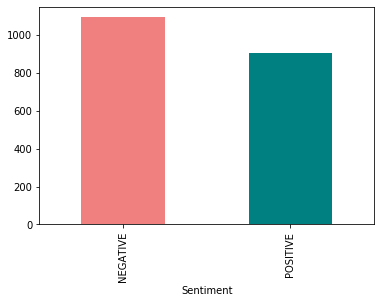

In [9]:
plt.figure()
df_labels.groupby('Sentiment').Int_ID.nunique().plot(kind = 'bar', color=['lightcoral','teal'])

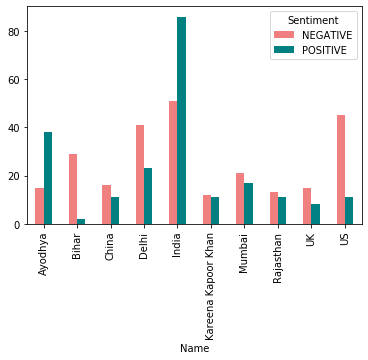

In [10]:
tweettags_t10 = top_n_tags_tweet(df_labels, 10)
tweettags_t10.groupby(['Name','Sentiment']).count()['Int_ID'].unstack().plot(kind = 'bar',color=['lightcoral','teal'])

### HDFC Bank hashtag

In [11]:
term = '#hdfcbank'
no_of_tweets = 2000
stype = 'Search'

df_labels = tweet_to_tagged_df(term, stype, no_of_tweets)
df_labels.to_pickle('hdfc_tweet_tags.pkl')

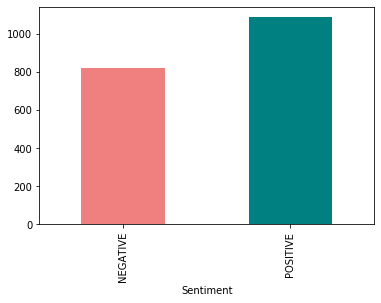

In [12]:
plt.figure()
df_labels.groupby('Sentiment').Int_ID.nunique().plot(kind = 'bar', color=['lightcoral','teal'])

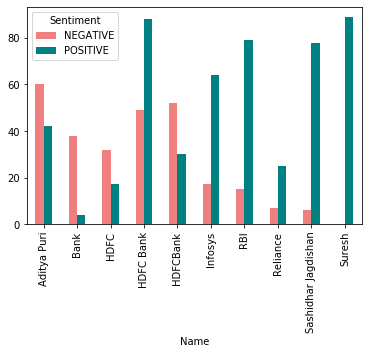

In [16]:
tweettags_t10 = top_n_tags_tweet(df_labels, 10)
tweettags_t10.groupby(['Name','Sentiment']).count()['Int_ID'].unstack().plot(kind = 'bar',color=['lightcoral','teal'])

## Future Efforts

Through this notebook, the abilities of Flair and its libraries are demonstrated and many functions were defined that can with limited code extract, sentiment classify and NER tag raw tweets from twitter feed. The future endeavours will be focused towards further analyzing the tags and sentiments for inferences and better represent visually such results.

## References

1. https://github.com/flairNLP/flair (Flair library published by the Humbolt University)